In [49]:
import uproot
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib.colors import LogNorm

In [50]:
import matplotlib.pyplot as plt

In [51]:
infile_name = 'build/events.root'
infile = uproot.open(infile_name)
event_dir=infile['events']
events = infile['events']["events"]

In [52]:
keys = infile.keys()

print(keys)

['G4VERSION_TAG;1', 'events;1', 'events/nbevents;1', 'events/events;2', 'events/events;1', 'G4RUNTIME;1', 'RANDOM_SEED;1']


In [53]:
primaries = events['xp_pri'].array(library="pd")
entries = len(primaries)
print(entries)

5585


In [54]:
def read_root_dir_minimal(fn, treename='events', output_type='df'):
    '''
    Output types can be 'df' for pandas dataframe or 'array' for numpy array.
    '''
    with uproot.open(fn) as f:
        tree = f[f"{treename}"][f"{treename}"]
        branches = ['nsteps', 'xp', 'yp', 'zp', 'PreStepEnergy', 'etot', 'parentid', 'xp_pri', 'yp_pri', 'zp_pri', 'ed']
        data = tree.arrays(branches, filter_name='nsteps', library='np')
        
        # Apply selection: NAct > 0
        mask = data['nsteps'] >= 0
        filtered_data = {key: value[mask] for key, value in data.items()}
        
        if output_type == 'df':
            return pd.DataFrame(filtered_data)
        elif output_type == 'array':
            return filtered_data
        else:
            print(f'Warning: output type you specified is {output_type}, not understood, returning numpy array...')
            return filtered_data

In [55]:
row_length = ('nsteps')
scalar_fields = ['etot', 'xp_pri', 'yp_pri', 'zp_pri']
vector_fields = ['xp', 'yp', 'zp', 'PreStepEnergy', 'parentid', 'ed']

def flatten_mc_tree(df, row_length=row_length, vector_fields=vector_fields, scalar_fields=scalar_fields):
    flattened_data = []
    for i, row in df.iterrows():
        # Check lengths just in case
        assert row[row_length] == len(row[vector_fields[0]])

        for j in range(row[row_length]):
            new_row = {}
            new_row['event'] = i
            new_row['particle'] = j

            for key in scalar_fields:
                new_row[key] = row[key]

            for key in vector_fields:
                new_row[key] = row[key][j]

            flattened_data.append(new_row)
   
    df_flattend = pd.DataFrame(flattened_data)
    df_flattend.set_index(['event', 'particle',])  # MultiIndex

    return df_flattend

In [56]:
df_raw = read_root_dir_minimal(infile_name, 'events')
print(len(df_raw))
print(len(df_raw[df_raw['etot']>0]))

5585
2305


In [48]:
df_raw['xp_pri']

0      762.062927
1      100.354866
2     1098.914551
3    -1639.519531
4      -71.758812
5    -1603.732300
6     -509.601166
7      373.279144
8    -1636.182251
9     1243.556152
10    1055.297241
11     305.204926
12    -305.599579
13    1260.901733
14   -1273.803711
15    1312.529053
16   -1160.875244
17     544.889282
18     919.600342
19   -1367.913330
20   -1214.975952
21    -512.116760
22    -488.455109
23    1514.760864
24     423.746704
25     361.406830
26     529.893555
27     945.362732
28     587.168152
29    -673.850891
30    -497.124603
31    1376.638428
32   -1260.091187
33    1084.656738
34   -1513.718384
35    1543.069702
36   -1508.708008
37    -785.517700
38    -958.498962
39    -567.069824
40   -1020.828369
41    -994.223145
42     994.953735
43    -755.469788
44     888.248840
45   -1212.105225
46     134.859894
47     444.931732
48   -1475.585327
49    1483.918823
50    -775.771912
51   -1712.015991
52    1019.317566
53    -167.201920
54    -832.654663
55    -665

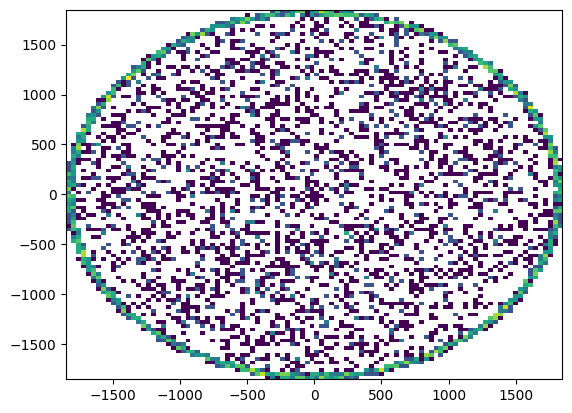

In [57]:
plt.hist2d(df_raw['xp_pri'],df_raw['yp_pri'], bins=[100, 100], norm=LogNorm())
plt.show()

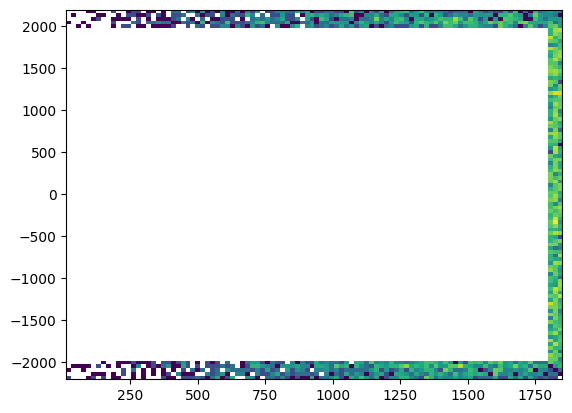

In [59]:
plt.hist2d(np.sqrt(df_raw['xp_pri']**2+df_raw['yp_pri']**2), df_raw['zp_pri'], bins=[100, 100], norm=LogNorm())
plt.show()

In [38]:
from numpy.polynomial import legendre
A_d = [[0.025, 0.819, 0, 0.181, 0, 0], 
       [0.125, 0.785, 0, 0.215, 0, 0],
       [0.310, 0.758, 0, 0.241, 0, 0.001],
       [0.520, 0.737, 0, 0.261, 0, 0.002],
       [0.780, 0.719, 0, 0.279, 0, 0.002],
       [1.060, 0.705, 0, 0.292, 0, 0.003],
       [1.350, 0.692, 0, 0.304, 0, 0.004],
       [1.660, 0.681, 0, 0.314, 0, 0.005],
       [2.000, 0.671, 0, 0.323, 0, 0.006]]

m_deuteron = 1875633 #keV
m_helium3=2809388 #keV
m_neutron = 939576 #keV
products=['helium3', 'neutron']
product_mass=[m_helium3/1000, m_neutron/1000]
mass = [m_deuteron/1000, m_deuteron/1000]
Q=3.269 #MeV

def determine_weight(angle, E_a):
    #angle = np.pi-angle
    
    leg_coefficients = A_d[np.clip(np.rint(E_a/0.010).astype(int)-2, 0, 8)][1:]
    cross_section = A_d[np.clip(np.rint(E_a/0.010).astype(int)-2, 0, 8)][0]
    
    #Weighting factor as function of emission angle using Liskien1982
    weight_prime = legendre.legval(angle, leg_coefficients)*cross_section
    #weight       = weight_prime/dtheta_dthetaprime
    return weight_prime

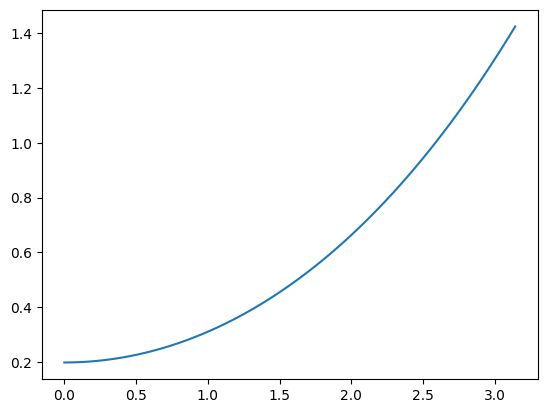

In [39]:
angles = np.linspace(0, np.pi, 100)
plt.plot(angles, determine_weight(angles, 0.040))

In [40]:
df_raw['primary_phi'] = primary_phi
df_raw['weight'] = determine_weight(np.array(primary_phi), 0.040)

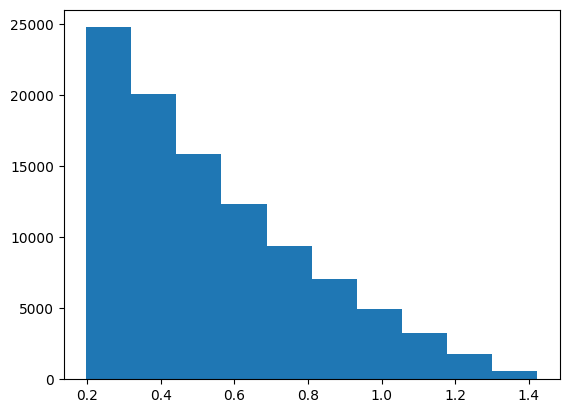

In [41]:
plt.hist(df_raw['weight'])
plt.show()

In [42]:
df_edep = df_raw[df_raw['etot']>0]

100000


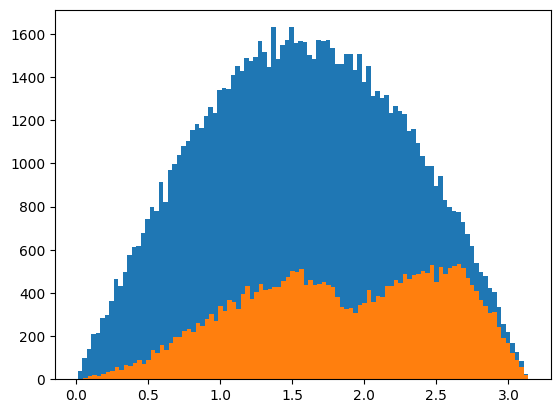

In [43]:
print(len(primary_phi))
plt.hist(df_raw['primary_phi'], bins=100)
plt.hist(df_edep['primary_phi'], bins=100)
#plt.yscale('log')
plt.show()

100000


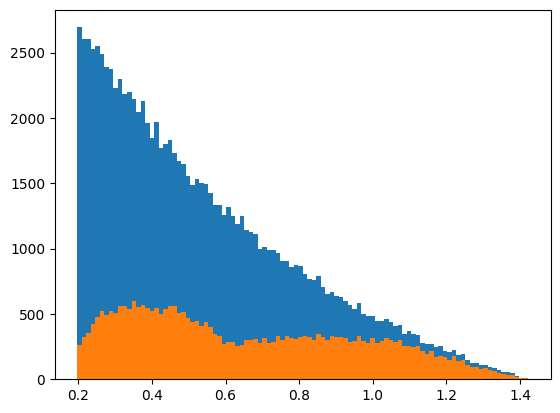

In [44]:
print(len(primary_phi))
plt.hist(df_raw['weight'], bins=100)
plt.hist(df_edep['weight'], bins=100)
plt.show()

In [45]:
total_weight = np.sum(df_raw['weight'])
recorded_weight = np.sum(df_raw[df_raw['etot']>0]['weight'])
recorded_weight/total_weight

np.float64(0.37621253113852743)

In [46]:
df = flatten_mc_tree(df_raw)

In [47]:
df_unique = df.drop_duplicates('event')
df_unique = df_unique[df_unique['etot']>0]
df_edep['x0']  = df_unique['xp'].values
df_edep['y0']  = df_unique['yp'].values
df_edep['z0']  = df_unique['zp'].values

/tmp/ipykernel_1357/4085157725.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_edep['x0']  = df_unique['xp'].values
/tmp/ipykernel_1357/4085157725.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_edep['y0']  = df_unique['yp'].values
/tmp/ipykernel_1357/4085157725.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

### All at phi 90

In [20]:
#Detectors at 0 threshold for all at 90
total_weight = np.sum(df_raw['weight'])

### Events in det_1
df_det1 = df_edep[df_edep['x0']>42]
recorded_weight = np.sum(df_det1['weight'])
print('Det 1 : %.2f ' %(100*recorded_weight/total_weight))

### Events in det_2
df_det2 = df_edep[df_edep['x0']<-42]
recorded_weight = np.sum(df_det2['weight'])
print('Det 2 : %.2f ' %(100*recorded_weight/total_weight))

### Events in det_3
df_det3 = df_edep[df_edep['y0']<-42]
recorded_weight = np.sum(df_det3['weight'])
print('Det 3 : %.2f ' %(100*recorded_weight/total_weight))

Det 1 : 4.87 
Det 2 : 4.89 
Det 3 : 4.79 


In [27]:
total_weight = np.sum(df_raw['weight'])
det1_thresh = []
det2_thresh = []
det3_thresh = []
energy_thresh = np.linspace(10, 2000, 399)

for i in energy_thresh:
    det1_thresh.append(np.sum(df_det1[df_det1['etot']>i]['weight'])/total_weight)
    det2_thresh.append(np.sum(df_det2[df_det2['etot']>i]['weight'])/total_weight)
    det3_thresh.append(np.sum(df_det3[df_det3['etot']>i]['weight'])/total_weight)


Text(0.5, 1.0, 'Efficiency vs Energy Threshold [keV], 3 Detectors at 90')

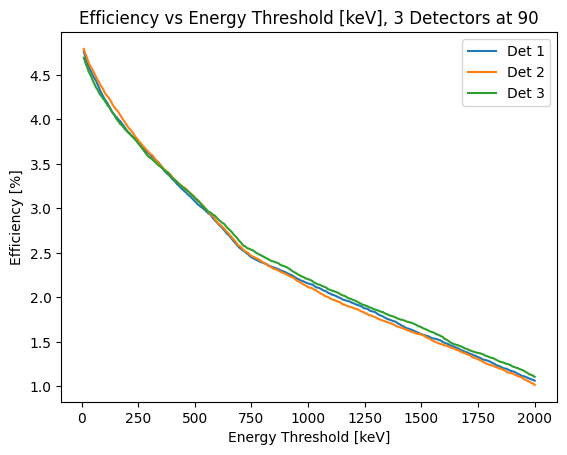

In [29]:
plt.plot(energy_thresh, np.array(det1_thresh)*100, label='Det 1')
plt.plot(energy_thresh, np.array(det2_thresh)*100, label='Det 2')
plt.plot(energy_thresh, np.array(det3_thresh)*100, label='Det 3')
plt.ylabel('Efficiency [%]')
plt.xlabel('Energy Threshold [keV]')
plt.legend()
plt.title('Efficiency vs Energy Threshold [keV], 3 Detectors at 90')

In [30]:
phi90 = {'E_ee' : energy_thresh,
         'Det1' : det1_thresh,
         'Det2' : det2_thresh,
         'Det3' : det3_thresh}
np.save('Phi90_3Detectors.npy', phi90)

### One At Phi 0

In [48]:
#Detectors at 0 threshold for one at 0
total_weight = np.sum(df_raw['weight'])

### Events in det_1
df_det1 = df_edep[df_edep['x0']>42]
recorded_weight = np.sum(df_det1['weight'])
print('Det 1 : %.2f ' %(100*recorded_weight/total_weight))

### Events in det_2
df_det2 = df_edep[df_edep['x0']<-42]
recorded_weight = np.sum(df_det2['weight'])
print('Det 2 : %.2f ' %(100*recorded_weight/total_weight))

### Events in det_3
df_det3 = df_edep[(df_edep['x0']<42)&(df_edep['x0']>-42)]
recorded_weight = np.sum(df_det3['weight'])
print('Det 3 : %.2f ' %(100*recorded_weight/total_weight))

Det 1 : 4.05 
Det 2 : 3.94 
Det 3 : 29.63 


In [49]:
total_weight = np.sum(df_raw['weight'])
det1_thresh = []
det2_thresh = []
det3_thresh = []
energy_thresh = np.linspace(10, 2000, 399)

for i in energy_thresh:
    det1_thresh.append(np.sum(df_det1[df_det1['etot']>i]['weight'])/total_weight)
    det2_thresh.append(np.sum(df_det2[df_det2['etot']>i]['weight'])/total_weight)
    det3_thresh.append(np.sum(df_det3[df_det3['etot']>i]['weight'])/total_weight)

Text(0.5, 1.0, 'Efficiency vs Energy Threshold [keV], 1 Detector at 0')

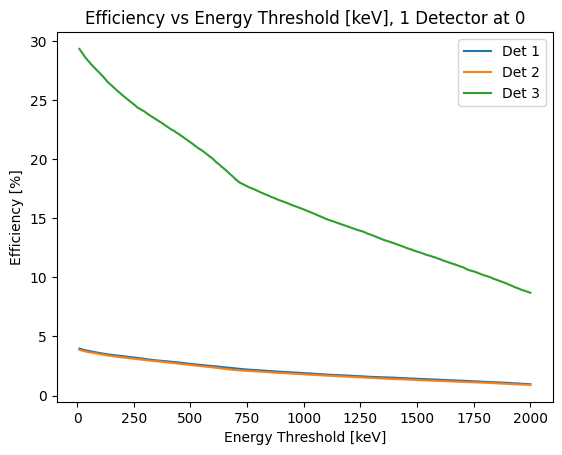

In [50]:
plt.plot(energy_thresh, np.array(det1_thresh)*100, label='Det 1')
plt.plot(energy_thresh, np.array(det2_thresh)*100, label='Det 2')
plt.plot(energy_thresh, np.array(det3_thresh)*100, label='Det 3')
plt.ylabel('Efficiency [%]')
plt.xlabel('Energy Threshold [keV]')
plt.legend()
plt.title('Efficiency vs Energy Threshold [keV], 1 Detector at 0')

In [51]:
phi0 = {'Det1' : det1_thresh,
         'Det2' : det2_thresh,
         'Det3' : det3_thresh}
np.save('Phi0_3Detectors_n52mm.npy', phi0)

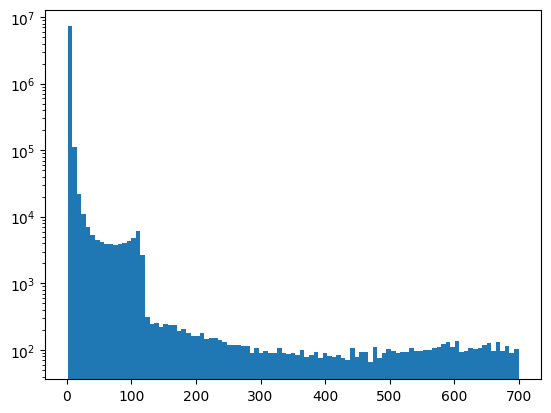

In [151]:

plt.hist(df['ed'], bins=np.linspace(1,700,100))
plt.yscale('log')
plt.show()